In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import dill
import hydra
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append("/home/diffusion_policy")
from diffusion_policy.dataset.base_dataset import BaseImageDataset
from diffusion_policy.policy.base_image_policy import BaseImagePolicy
from diffusion_policy.workspace.base_workspace import BaseWorkspace

precision = 4
np.set_printoptions(suppress=True, precision=precision)
torch.set_printoptions(precision=precision, sci_mode=False)

In [3]:
# rundir = "/home/diffusion_policy/data/outputs/2023.04.03/03.30.24_train_diffusion_unet_hybrid_pick_up_ball"
rundir = "/home/diffusion_policy/data/outputs/2023.04.05/01.34.51_train_diffusion_unet_hybrid_move_forward"
ckpt_path = os.path.join(rundir, "checkpoints", "latest.ckpt")

In [4]:
payload = torch.load(open(ckpt_path, 'rb'), pickle_module=dill)
cfg = payload['cfg']

In [5]:
batch_size = 25
cfg["dataloader"]["batch_size"] = batch_size
cfg["dataloader"]["pin_memory"] = False
cfg["val_dataloader"]["batch_size"] = batch_size
cfg["val_dataloader"]["pin_memory"] = False

In [6]:
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states']
using obs modality: rgb with keys: ['images']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/root/miniconda3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 6.502567e+07
Vision params: 1.119709e+07


In [7]:
policy: BaseImagePolicy
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device('cuda')
policy.eval().to(device)

# set inference params
policy.num_inference_steps = 200 # DDIM inference iterations
policy.n_action_steps = policy.horizon - policy.n_obs_steps + 1

In [8]:
# configure dataset
dataset: BaseImageDataset
dataset = hydra.utils.instantiate(cfg.task.dataset)
assert isinstance(dataset, BaseImageDataset)
train_dataloader = DataLoader(dataset, **cfg.dataloader)
normalizer = dataset.get_normalizer()

# configure validation dataset
val_dataset = dataset.get_validation_dataset()
val_dataloader = DataLoader(val_dataset, **cfg.val_dataloader)

In [9]:
batch = next(iter(train_dataloader))

In [86]:
policy.num_inference_steps = 100 # DDIM inference iterations
n_action_steps = 4
batch_idx = 23

In [87]:
result = policy.predict_action(batch["obs"])
pred_action = result['action_pred'].detach().cpu().numpy()

In [88]:
pred_action[batch_idx, :n_action_steps]

array([[ 0.5876, -0.0682,  0.4774,  3.0082,  0.173 ,  0.1355,  0.0478],
       [ 0.6408, -0.0452,  0.4784,  2.8877,  0.1736,  0.1471, -0.0182],
       [ 0.6491, -0.0304,  0.4845,  3.1174,  0.1777,  0.1757, -0.0734],
       [ 0.6951, -0.0351,  0.4652,  2.7006,  0.1816,  0.1686,  0.0338]],
      dtype=float32)

In [89]:
gt_action = batch["action"]

In [90]:
gt_action[batch_idx, :n_action_steps].detach().cpu().numpy()

array([[ 0.6435, -0.0288,  0.4656,  2.9337,  0.1622,  0.2072,  0.    ],
       [ 0.6697, -0.017 ,  0.4576,  2.9243,  0.1522,  0.1995,  0.    ],
       [ 0.6967, -0.006 ,  0.4502,  2.9202,  0.1522,  0.2003,  0.    ],
       [ 0.7173,  0.0013,  0.4433,  2.9193,  0.1527,  0.1936,  0.    ]],
      dtype=float32)

In [ ]:
batch["obs"]["images"].shape

In [ ]:
batch["obs"]["joint_states"][batch_idx].detach().cpu().numpy()

- why is that 16 timesteps?

In [ ]:
policy.n_obs_steps

In [ ]:
img = batch["obs"]["images"][batch_idx, 15].detach().cpu().numpy().transpose(1,2,0)

In [ ]:
plt.imshow(img)

In [ ]:
batch_idx = 23
batch["obs"]["images"].shape
images = batch["obs"]["images"][batch_idx].detach().cpu().numpy().transpose(0,2,3,1)
images = (images * 255).astype(np.uint8)

In [ ]:
images.shape

In [ ]:
import imageio
from IPython.display import Video


In [ ]:
output_filepath = "/home/video/output.mp4"
writer = imageio.get_writer(output_filepath, fps=15)
for i in range(images.shape[0]):
    writer.append_data(images[i])
writer.close()

In [ ]:
from ipywidgets import Video
Video.from_file(output_filepath, width=320, height=320)

In [ ]:
with torch.no_grad():
    dataloader = train_dataloader

    pred, gt = [], []

    for i, batch in enumerate(dataloader):
        result = policy.predict_action(batch["obs"])
        pred_action = result['action_pred'].detach().cpu().numpy()
        pred.append(pred_action)

        gt_action = batch["action"]
        gt_action= gt_action.detach().cpu().numpy()
        gt.append(gt_action)

        if i > 30:
            break

In [ ]:
pred = np.concatenate(pred)
gt = np.concatenate(gt)

In [ ]:
n_pred_timestep = 8
error = np.sqrt((pred[:,:n_pred_timestep] - gt[:, :n_pred_timestep]) ** 2)
error.mean(axis=(0,1))

In [ ]:
pred[0]

In [ ]:
gt[0]

#
train: 0.0072, 0.0047, 0.0066, 0.1946, 0.0163, 0.0182, 0.007
val:   0.0223, 0.0155, 0.0212, 0.7429, 0.0603, 0.0578, 0.027 


- I'm suspicious of the first euler angle values
- the outputs seem to be very inconsistent
- are they inconsistent in the training data?
- is the normalization doing something weird?

In [99]:
policy.normalizer["action"].params_dict["offset"]

Parameter containing:
tensor([    -1.9983,     -0.0784,     -3.7155,     -0.0005,      0.0311,
            -0.4637,      0.0000], device='cuda:0')

In [101]:
policy.normalizer["action"].params_dict["scale"]

Parameter containing:
tensor([3.6617, 4.6023, 7.8533, 0.3185, 2.9818, 3.6831, 1.0000],
       device='cuda:0')

- ok so the offset is tiny so that's probably fine
- but the scale is quite small
- which I assume means that it's range is small 
    - is that the case
    - how are the limits computed?
    

In [120]:
actions = []
for i, batch in enumerate(train_dataloader):
    if i > 10:
        break
    actions.append(batch["action"])
actions = torch.cat(actions).reshape(-1, 7)
actions = actions.detach().cpu().numpy()

(array([494., 130.,  99., 343.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  12., 113.,  52., 463., 295., 368., 595., 379., 600.,
        457.]),
 array([-3.1381, -3.0753, -3.0125, -2.9497, -2.8869, -2.8241, -2.7614,
        -2.6986, -2.6358, -2.573 , -2.5102, -2.4474, -2.3846, -2.3218,
        -2.259 , -2.1962, -2.1334, -2.0706, -2.0078, -1.945 , -1.8822,
        -1.8195, -1.7567, -1.6939, -1.6311, -1.5683, -1.5055, -1.4427,
        -1.3799, -1.3171, -1.2543,

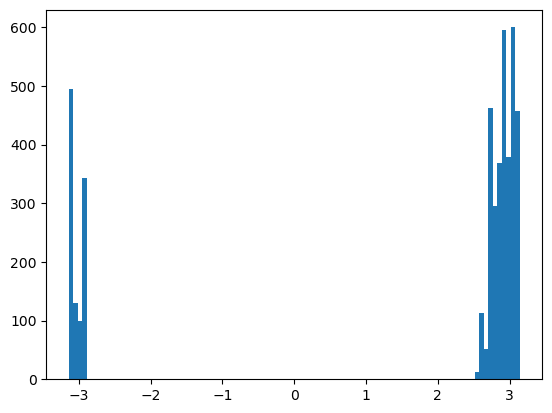

In [125]:
plt.hist(actions[:, 3], bins=100)